In [1]:
import random
import time
import numpy as np

import GameHard
import DisplayIA

env = GameHard.Game()

import tensorflow as tf
from tensorflow import keras

import multiprocessing

%matplotlib inline
import matplotlib.pyplot as plt

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
input_shape = [15, 2]
n_outputs = 3

tf.keras.backend.set_floatx('float64')
"""
K = keras.backend
input_states = keras.layers.Input(shape=input_shape)
#hidden1 = keras.layers.Flatten()(input_states)
#hidden2 = keras.layers.Dense(300, activation="relu")(hidden1)
hidden3 = keras.layers.Dense(50, activation="relu")(input_states)
hidden4 = keras.layers.Dense(30, activation="relu")(hidden3)
hidden5 = keras.layers.Flatten()(hidden4)
state_values = keras.layers.Dense(1)(hidden5)
raw_advantages = keras.layers.Dense(n_outputs)(hidden5)
advantages = raw_advantages - K.max(raw_advantages, axis=1, keepdims=True)
Q_values = state_values + advantages
model = keras.Model(inputs=[input_states], outputs=[Q_values])
"""


model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=input_shape),
    keras.layers.Dense(300, activation="relu", kernel_initializer=keras.initializers.VarianceScaling()),
    keras.layers.Dense(200, activation="relu", kernel_initializer=keras.initializers.VarianceScaling()),
    keras.layers.Dense(300, activation="relu", kernel_initializer=keras.initializers.VarianceScaling()),
    keras.layers.Dense(n_outputs, kernel_initializer=keras.initializers.VarianceScaling())
])

target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [3]:
predicted_left_count = 0
predicted_static_count = 0
predicted_right_count = 0

In [4]:
def epsilon_greedy_policy(state, epsilon=0):
    global predicted_static_count, predicted_left_count, predicted_right_count
    if np.random.rand() < epsilon:
        predicted_value = np.random.randint(3)
        return predicted_value
    else:
        Q_values = model.predict(state[np.newaxis])
        predicted_value = np.argmax(Q_values[0])
        if predicted_value == 0 :
            predicted_static_count += 1
        elif predicted_value == 1 :
            predicted_left_count += 1
        elif predicted_value == 2 :
            predicted_right_count += 1
        return predicted_value

In [5]:
from collections import deque

#replay_buffer = deque(maxlen=100000)

priority_scale = 0.7

class ReplayBuffer():
    def __init__(self):
        self.buffer = deque(maxlen=100000)
        self.priorities = deque(maxlen=100000)
        
    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(np.amax(self.priorities, initial=1))
        
    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities) ** priority_scale
        sample_probabilities = scaled_priorities / sum(scaled_priorities)
        return sample_probabilities
    
    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance / max(importance)
        return importance_normalized
    
    def sample(self, batch_size):
        #indices = np.random.randint(len(self.buffer), size=batch_size)
        sample_probs = self.get_probabilities(priority_scale)
        indices = np.random.choice(range(len(self.buffer)), batch_size, p=sample_probs)
        batch = [self.buffer[index] for index in indices]
        states, actions, rewards, next_states, dones = [
            np.array([experience[field_index] for experience in batch])
            for field_index in range(5)]
        importances = self.get_importance(sample_probs[indices])
        return indices, states, actions, rewards, next_states, dones, importances
    
    def set_priorities(self, indices, errors):
        for i, e in zip(indices, errors):
            self.priorities[i] = abs(e) + 0.1
    
replay_buffer = ReplayBuffer()

In [6]:
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_buffer), size=batch_size)
    batch = [replay_buffer[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [7]:
"""def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    cumulative_reward = 0
    cumulative_done = False
    next_state = None
    for i in range(4):
        next_state, reward, done, info = env.step(action)
        cumulative_reward += reward
        if (done):
            cumulative_done = True
            break
    next_state = np.divide(next_state, 1000)
    replay_buffer.append((state, action, cumulative_reward, next_state, cumulative_done))
    return next_state, cumulative_reward, cumulative_done, info
    
    # one frame version
    next_state, reward, done, info = env.step(action)
    next_state = np.divide(next_state, 1000)
    replay_buffer.append((state, action, reward, next_state, done))
    return next_state, reward, done, action"""

def play_one_step(env, state, epsilon, action=None):
    if action == None :
        action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    next_state = next_state.astype(np.float64)
    next_state = np.divide(next_state, 1000)
    replay_buffer.add((state, action, reward, next_state, done))
    return next_state, reward, done, action

In [8]:
batch_size = 64
discount_factor = 0.99
optimizer = keras.optimizers.RMSprop(lr=2.5e-4, rho=0.95, momentum=0.0, epsilon=0.00001, centered=True)
loss_fn = keras.losses.Huber(reduction="none")




#model.compile(loss=loss_fn, optimizer=optimizer)

In [9]:
def training_step(batch_size):
    experiences = replay_buffer.sample(batch_size)
    states, actions, rewards, next_states, dones, importances = experiences
    next_Q_values = model.predict(next_states)
    print(next_Q_values)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    print(best_next_actions)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = rewards + (1 - dones) * discount_factor * next_best_Q_values
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        mask = tf.cast(mask, tf.float64)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
def training(batch_size):
    experiences = replay_buffer.sample(batch_size)
    indices, states, actions, rewards, next_states, dones, importances = experiences
    value_next = np.max(target.predict(next_states), axis=1)
    actual_values = np.where(dones, rewards, rewards+discount_factor*value_next)
    
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        mask = tf.one_hot(actions, n_outputs)
        mask = tf.cast(mask, tf.float64)
        selected_action_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        #selected_action_values = tf.math.reduce_sum(model.predict(states) * tf.one_hot(actions, n_outputs), keepdims=True)
        error = actual_values - selected_action_values
        replay_buffer.set_priorities(indices, error)
        loss = tf.math.reduce_mean(tf.multiply(tf.square(error), importances))
    variables = model.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    return loss

In [10]:
#Play random for a few episodes
for episode in range(1000):
    obs = env.reset()
    obs = np.divide(obs, 1000)
    
    for step in range(5000):
        obs, rewards, done, info = play_one_step(env, obs, 1, None)
        if done:
            break
    
    if episode % 500 == 0:
        print(episode)

0
500


step number : 0
episode number : 0
predicted static : 0
predicted left : 0
predicted right : 0


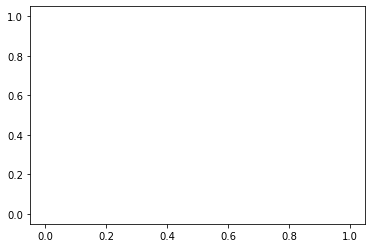

In [ ]:
#Trying something else

#Init variable
obs = env.reset()
obs = obs.astype(np.float64)
obs = np.divide(obs, 1000)

episode = 0
total_rewards = []

episode_total_rewards = 0

repeat = 0
action_to_repeat = 0
for step in range(500000):
    epsilon = max(1 - (step / 150000), 0.01)
    
    if repeat == 0 :
        obs, rewards, done, info = play_one_step(env, obs, epsilon, None)
        repeat = 3
        action_to_repeat = info
    else :
        obs, rewards, done, info = play_one_step(env, obs, epsilon, action_to_repeat)
        repeat -= 1
    episode_total_rewards += rewards
    
    if done :
        obs = env.reset()
        obs = np.divide(obs, 1000)
        episode += 1
        total_rewards = np.append(total_rewards, episode_total_rewards)
        episode_total_rewards = 0
    
    if step % 4 == 0 :
        training(batch_size)
    if step % 2000 == 0:
        target.set_weights(model.get_weights())
    
    if step % 10000 == 0 :
        print("step number : " + str(step))
        print("episode number : " + str(episode))
        
        print("predicted static : " + str(predicted_static_count))
        print("predicted left : " + str(predicted_left_count))
        print("predicted right : " + str(predicted_right_count))
        
        random_static_count = 0
        random_left_count = 0
        random_right_count = 0
        predicted_static_count = 0
        predicted_left_count = 0
        predicted_right_count = 0
        
        scores = []
        model.save('kerasDQL.h5')
        plt.plot(total_rewards)
        plt.show()

In [ ]:
"""total_rewards = []

scores = []
for episode in range(30000):       


    obs = env.reset()
    obs = np.divide(obs, 1000)

    episode_total_rewards = 0

    for step in range(50000):
        epsilon = max(1 - episode / 7500, 0.01)
        obs, rewards, done, info = play_one_step(env, obs, epsilon)
        episode_total_rewards += rewards
        if done:
            scores = np.append(scores, episode_total_rewards)
            total_rewards = np.append(total_rewards, episode_total_rewards)
            break
        if episode > 100 and episode < 3000 and step % 2000 == 0:
            training_step(batch_size)
    if episode % 50 == 0 :
        target.set_weights(model.get_weights())
    if episode % 500 == 0 :
        print("episode number : " + str(episode))
        print("mean score : " + str(np.mean(scores)))
        
        print("random static : " + str(random_static_count))
        print("random left : " + str(random_left_count))
        print("random right : " + str(random_right_count))
        print("predicted static : " + str(predicted_static_count))
        print("predicted left : " + str(predicted_left_count))
        print("predicted right : " + str(predicted_right_count))
        
        random_static_count = 0
        random_left_count = 0
        random_right_count = 0
        predicted_static_count = 0
        predicted_left_count = 0
        predicted_right_count = 0
        
        scores = []
        model.save('kerasDQL.h5')
        plt.plot(total_rewards)
        plt.show()"""

In [ ]:
model.save('kerasDQL.h5')

In [ ]:
250000 // 4